**This Notebook aims to categorize (A-F cat.) the pannel based on its features using a convolutionnal neural network**<br>
The model can then be used conviniently without having to re-fit it

In [9]:
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from keras.utils import to_categorical
import os
import sklearn.cluster
from sklearn.model_selection import train_test_split
import itertools
import statistics
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import scipy
from scipy import signal

In [10]:
def make_labels(directory, data=[], y_hat=[], label=0):
    for root, dirs, files in os.walk(directory):
        for file in files:
            img = matplotlib.image.imread(directory + file)
            
            # Ensure the image has 3 channels (RGB)
            if img.shape[-1] == 4:
                img = img[:, :, :3]
                
            img = cv2.resize(img, (224, 224))
            data.append(img)
        y_hat = [label] * len(data)
    return np.array(data), np.array(y_hat)

In [11]:
parent_folder = 'Training/augmentation1/'

a, y_a = [], []
a, y_a = make_labels(parent_folder + '/A/', data=a, y_hat=y_a, label=0)
print("a loaded")

b, y_b = [], []
b, y_b = make_labels(parent_folder + '/B/', data=b, y_hat=y_b, label=1)
print("b loaded")

c, y_c = [], []
c, y_c = make_labels(parent_folder + '/C/', data=c, y_hat=y_c, label=2)
print("c loaded")

d, y_d = [], []
d, y_d = make_labels(parent_folder + '/D/', data=d, y_hat=y_d, label=3)
print("d loaded")

e, y_e = [], []
e, y_e = make_labels(parent_folder + '/E/', data=e, y_hat=y_e, label=4)
print("e loaded")

f, y_f = [], []
f, y_f = make_labels(parent_folder + '/F/', data=f, y_hat=y_f, label=5)
print("f loaded")

a loaded
b loaded
c loaded
d loaded
e loaded
f loaded


In [12]:
print('a:', a.shape)
print('b:', b.shape)
print('c:', c.shape)
print('d:', d.shape)
print('e:', e.shape)
print('f:', f.shape)

a: (192, 224, 224, 3)
b: (192, 224, 224, 3)
c: (192, 224, 224, 3)
d: (192, 224, 224, 3)
e: (192, 224, 224, 3)
f: (192, 224, 224, 3)


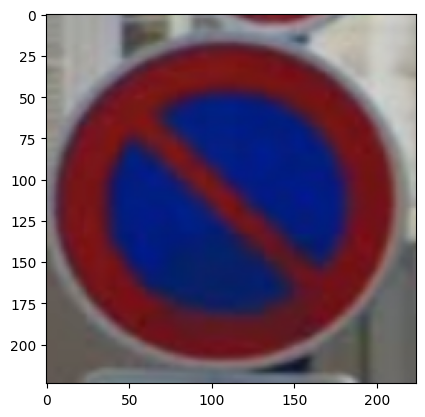

In [13]:
plt.imshow(e[0]);
plt.show()

In [14]:
def detect_non_parking_sign(image):

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the color range for blue (you may need to adjust these values)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])

    # Create a binary mask for blue color
    mask_blue = cv2.inRange(hsv_image, lower_blue, upper_blue)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through contours
    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # Set a threshold for contour area (you may need to adjust this value)
        threshold_area = 500

        # Check if the contour area exceeds the threshold
        if area > threshold_area:
            # Draw a bounding box around the contour
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Print or return a message indicating the detection
            return True

    # Print or return a message indicating no detection
    return False

**Data normalization**

In [15]:
X = np.vstack((a, b, c, d, e, f))
a = b = c = d = e = f = None
y = np.hstack((y_a, y_b, y_c, y_d, y_e, y_f)).reshape(-1, 1)
y_cat = to_categorical(y)
y = None

In [16]:
print(X.shape)
print(y_cat.shape)

(1152, 224, 224, 3)
(1152, 6)


**Create & compile the model**

In [17]:
model = Sequential()

# Add a Convolutional Layer with 32 filters, a kernel size of (3, 3), and input shape (224, 224, 3)
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))

# Add a MaxPooling Layer with pool size (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another Convolutional Layer with 64 filters and a kernel size of (3, 3)
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to feed into a Dense layer
model.add(Flatten())

# Add a Dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Add the output layer with 6 neurons (assuming 6 categories) and softmax activation
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

4


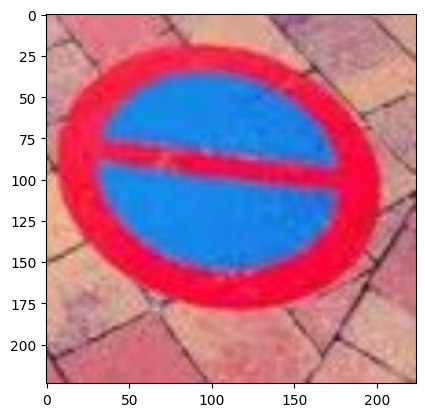

In [19]:
ind = 9

plt.imshow(X_train[ind]*255);
print(y_train[ind].argmax())

In [21]:
model.fit(X_train, y_train, epochs=10, batch_size=2, validation_data=(X_test, y_test))

Epoch 1/10


2023-12-18 09:14:20.859436: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554545152 exceeds 10% of free system memory.


461/461 [==============================] - 188s 405ms/step - loss: 1.7938 - accuracy: 0.1640 - val_loss: 1.7940 - val_accuracy: 0.1126
Epoch 2/10
461/461 [==============================] - 190s 412ms/step - loss: 1.7922 - accuracy: 0.1802 - val_loss: 1.7950 - val_accuracy: 0.1126
Epoch 3/10
461/461 [==============================] - 190s 412ms/step - loss: 1.7919 - accuracy: 0.1802 - val_loss: 1.7964 - val_accuracy: 0.1126
Epoch 4/10
461/461 [==============================] - 189s 410ms/step - loss: 1.7917 - accuracy: 0.1802 - val_loss: 1.7977 - val_accuracy: 0.1126
Epoch 5/10
461/461 [==============================] - 190s 412ms/step - loss: 1.7917 - accuracy: 0.1802 - val_loss: 1.7990 - val_accuracy: 0.1126
Epoch 6/10
249/461 [===============>..............] - ETA: 1:26 - loss: 1.7898 - accuracy: 0.1647

KeyboardInterrupt: 

: 